# Wigner Functions

Although the ZPG method is based on time-integrated photon-counting probabilities, it is also capable of simulating the time-integrated Wigner function $W(x,p)$ of a photonic state. The algorithm is based on the principle demonstrated in this paper [[K. Banaszek et al., Phys. Rev. A 60, 674 (1999)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.60.674)] that the Wigner function at the origin of phase space $W(0,0)$ is equal to the parity summation over all photon number probabilities:
\begin{equation}
W(0,0) = \frac{1}{\pi}\sum_n(-1)^np_n.
\end{equation}
Naively, we could imagine computing this by using photon_statistics() and summing over the result similar to how they implemented this in the paper. However, there is a remarkable similarity between this parity summation and the loss formula to determine the vacuum probability:
\begin{equation}
p_0(\eta)=\sum_{n}(1-\eta)^np_n
\end{equation}
By choosing to use an unphysically high detection efficiency of $\eta=2$ while simulating the vacuum probability, we can obtain the Wigner function at the origin $p_0(\eta=2)=\pi W(0,0)$ by computing just a single probability instead of all $p_n$ necessary for the parity summation to converge. This can provide a remarkable speed improvement for the direct simulation of time-integrated Wigner functions. Let's exploit this idea using ZPGenerator.


In [18]:
from zpgenerator import *
import numpy as np
import matplotlib.pyplot as plt

## Parity detector

By default, there are post-processing steps in the backend that prevent such a direct exploitation of the ZPG method by the user. However, we can specifically ask for this unphysical behaviour by using a special parity detector when building a processor. This detector indicates that we wish to use an unphysical $\eta=2$ to get a parity summation at the detector. See [Detectors](detectors_catalogue.ipynb) for more detail on this detector type.

Let's test this using an ideal single-photon source.

In [19]:
p = Processor()
p.add(0, Source.fock(1))
p.add(0, Detector.parity())
pn = p.probs().display()

Pattern | Expectation
p       | -1.00000



As expected for a single photon, we obtain the parity ('p') expectation value of $-1$ at the origin of phase space, corresponding to the Wigner function value of $-1/\pi$, as expected. We can try again for other Fock states to convince ourselves it is working.

In [20]:
for i in range(1, 6):
    p = Processor() // Source.fock(i) // Detector.parity()
    print("{n}: {p:.4}".format(n=i, p=p.probs()['p']))

1: -1.0
2: 1.0
3: -1.0
4: 1.0
5: -1.0


Here, we can see the alternating pattern from the parity summation formula.

## Shaped lasers

Of course, it is not very interesting to simulate the Wigner function just at the origin. To compute the Wigner function at any point in phase space with complex amplitude $\alpha$, we need to displace our light in phase space using a local oscillator (a laser pulse) before measuring $W(0,0)$ using the parity detector. This is the same approach as used to measure the Wigner function in [[K. Banaszek et al., Phys. Rev. A 60, 674 (1999)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.60.674)].

As simple as it sounds, displacing the light emitted by the source requires interfering its emission with the laser pulse at a beam splitter, and this beam splitter will cause photon loss for our signal and hence alter the measured Wigner function, just like it would if we performed this experiment in the lab. To get around this, we can use a beam splitter with a very high transmission and a laser pulse with many more photons than the signal. This way, the loss is minimized and yet the displacement is nearly perfect. However, simulating the exact quantum dynamics of a laser cavity with many photons would require many energy levels, which would in turn slow the simulation down immensely. Luckily, because a laser is in a classical coherent state, we need only simulate the quantum fluctuations induced on the laser cavity when measuring the displaced signal. In essence, we can get around simulating the full quantum dynamics of the laser cavity by it moving into a displaced frame defined by the time-evolution of the laser cavity would experience if we were not measuring the quantum signal.

Fortunately, ZPGenerator has this exact `displaced local oscillator' component as a catalogue source called shaped_laser(). See [Sources](sources_catalogue.ipynb) for more detail about this source type. For now, let's make it and compute its photon statistics for an amplitude of $\alpha=5$.

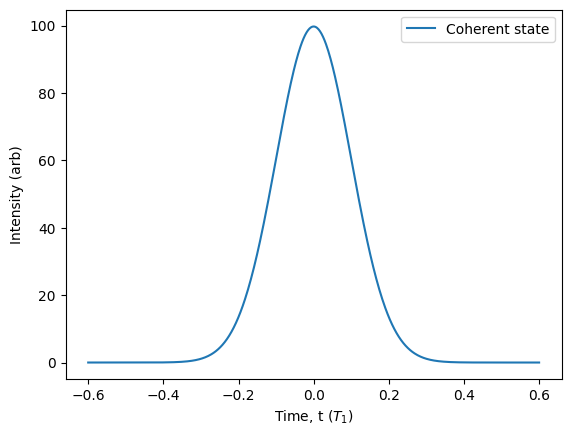

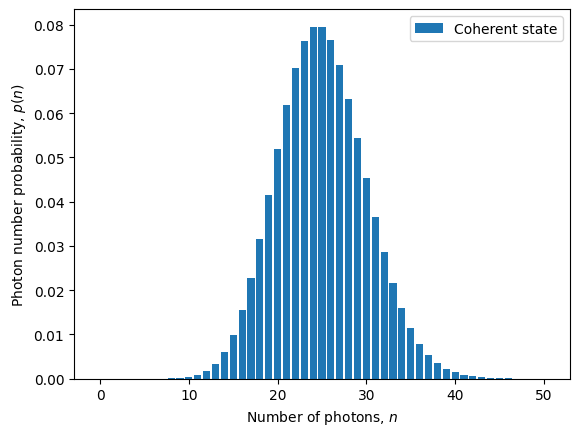

In [21]:
laser = Source.shaped_laser(shape=Pulse.gaussian(), parameters={'amplitude': 5})
laser.plot_lifetime(label='Coherent state').show()
laser.photon_statistics(truncation=50).plot(label='Coherent state').show()

We can see that we are still able to simulate the time-integrated photon statistics of a coherent pulse up to $n=50$ without actually simulating the full time dynamics of a 50-level laser cavity system. By default, the "quantum" part of the oscillator() source is truncated at just 2 energy levels, which can capture critical single-photon fluctuations of the local oscillator during homodyne measurement, while the "classical" part takes care of the coherent statistics that performs the displacement.

Note that, unlike other catalogue source types that take a pulse keyword, the oscillator takes the shape keyword. The difference being that the keyword 'pulse' is reserved for the excitation pulse of a quantum source, which then dictates the 'shape' of the emitted light. In the case of the oscillator, the shape keyword directly determines the temporal shape of the light emitted by the laser. This comes in handy if we want to shape our laser to interfere with the emission from another source.

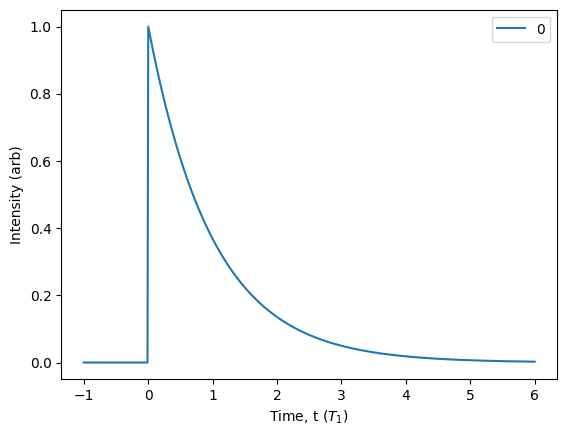

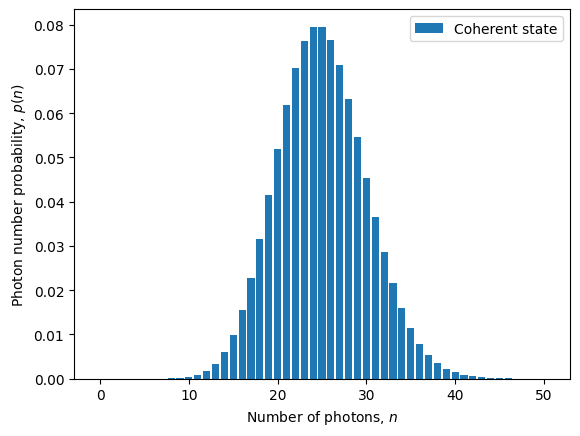

In [22]:
source = Source.fock(1)  # make the source we want to characterise
lifetime = source.lifetime()

# make the shaped laser pulse to perform homodyne tomography
laser = Source.shaped_laser(shape=lifetime, parameters={'amplitude': 5})
laser.plot_lifetime(start=-1, end=6, parameters={'amplitude': 1}).show()
laser.photon_statistics(truncation=50).plot(label='Coherent state').show()

Now we can see that the classica pulse has an exponentially-decaying temporal profile, yet it retains the Gaussian-distributed photon statistics of a coherent state.

## Unbalanced homodyne

Let's take a look at doing homodyne tomography now. Since we have constructed our source and shaped our laser, we interfere the emission from these sources at a highly-transmissive beam splitter with a parity detector at the output.

In [23]:
# build our unbalanced homodyne setup
R = 0.001  # beam splitter with reflectivity of 0.1%
theta_BS = np.arcsin(np.sqrt(R))  # turn that into a beam splitter angle
p = Processor()
p.add(0, source)
p.add(1, laser)
p.add(0, Circuit.bs(theta_BS))
p.add(0, Detector.parity())

# simulate the wigner function while tuning the local oscillator amplitude from -100 to 100
wigner = []
alphas = np.linspace(-100, 100, 100)
for alpha in alphas:
    wigner.append(p.probs(parameters={'amplitude': alpha})['p'])

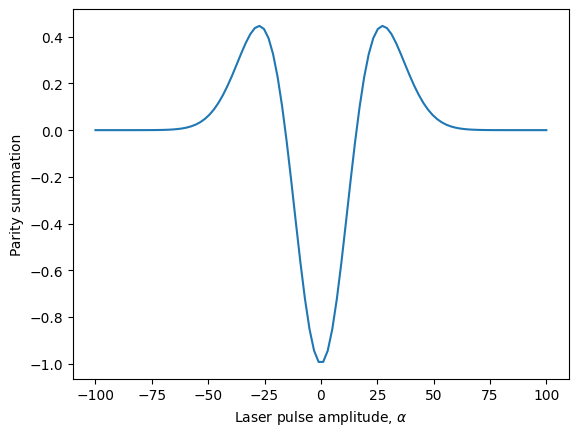

In [24]:
plt.plot(alphas, wigner)
plt.xlabel('Laser pulse amplitude, $\\alpha$')
plt.ylabel('Parity summation')
plt.show()

We can see that the shape looks correct for a single photon, but that the x- and y-axis scales are way off! To fix the y-axis, we must multiply the parity summation by $1/\pi$. The x-axis scale is off because the amount of laser that actually interferes with our source emission is limited by the high transmissivity of the beam splitter. Thus, we must correct for it by scaling the x-axis accordingly by the factor $\sqrt{2 R/(1-R)}$. With this correction, let's now compare our numerical simulation of unbalanced homodyne detection with the analytic solution:
$$
W_{|1\rangle}(\alpha) = \frac{2|\alpha|^2 - 1}{\pi} e^{-|\alpha|^2}
$$

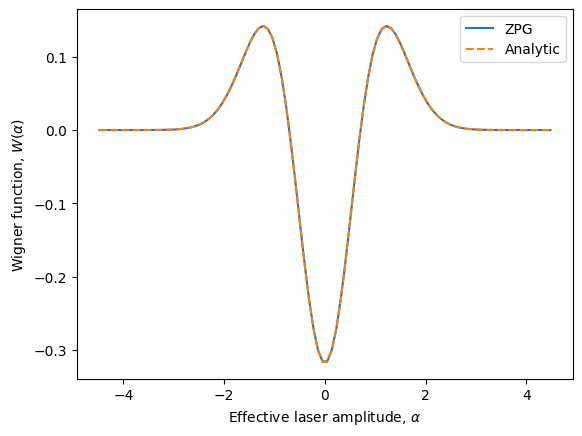

In [25]:
scaled_alpha = [a * np.sqrt(2*R/(1-R)) for a in alphas]
plt.plot(scaled_alpha, [w/np.pi for w in wigner], label='ZPG')
plt.plot(scaled_alpha, [np.exp(-a**2) * (2*a**2 - 1)/np.pi for a in scaled_alpha], label='Analytic', ls='dashed')
plt.legend()
plt.xlabel('Effective laser amplitude, $\\alpha$')
plt.ylabel('Wigner function, $W(\\alpha)$')
plt.show()

### Wigner method

Since the above procedure for characterising a source is the same for any source, it is bundled together as a characterisation method of the SourceComponent class called wigner(). Let's take this opportunity to check what $|2\rangle$ looks like:

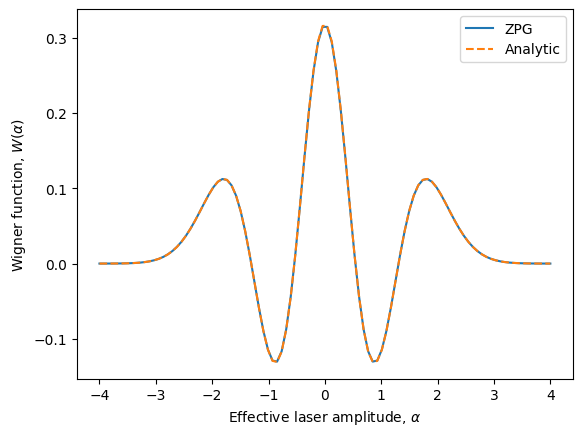

In [26]:
source = Source.fock(2)  # make our source we want to characterise

# simulate the wigner function while tuning the local oscillator amplitude from -100 to 100
alphas = np.linspace(-4, 4, 100)
wigner = source.wigner(alpha=alphas, pseudo_limit=0.001)

plt.plot(wigner.alphas, wigner.points, label='ZPG')
plt.plot(alphas, [np.exp(-a**2) * (1 - 4*a**2 + 2*a**4)/np.pi for a in alphas], label='Analytic', ls='dashed')
plt.legend()
plt.xlabel('Effective laser amplitude, $\\alpha$')
plt.ylabel('Wigner function, $W(\\alpha)$')
plt.show()

## Imperfections

Now that we have verified that the numerical approach matches the analytic solution, we can look at what happens to our Wigner function when we use an imperfect single-photon source. Now that we have imperfections, the result may not be symmetric. Let's look along both the X and P axes of the Wigner function.

Number  | Probability
0       | 0.09943
1       | 0.87399
2       | 0.02645
3       | 0.00014
4       | 0.00000



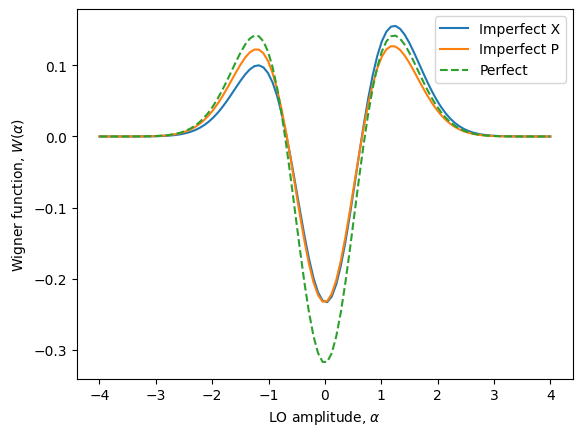

In [27]:
source = Source.two_level(pulse=Pulse.gaussian({'width': 0.1, 'dephasing': 0.1, 'detuning': 0.1}), efficiency=0.9)
source.photon_statistics().display()

alphas = np.linspace(-4, 4, 100)
wignerX = source.wigner(alpha=alphas)
wignerP = source.wigner(alpha=[1.j * a for a in alphas])

plt.plot(wignerX.alphas, wignerX.points, label='Imperfect X')
plt.plot(wignerX.alphas, wignerP.points, label='Imperfect P')
plt.plot(alphas, [np.exp(-a**2) * (2*a**2 - 1)/np.pi for a in alphas], label='Perfect', ls='dashed')
plt.legend()
plt.xlabel('LO amplitude, $\\alpha$')
plt.ylabel('Wigner function, $W(\\alpha)$')
plt.show()

With this approach, it is also straightforward to simulate the Wigner function of light produced by multi-pulse sequences. To demonstrate, let's look at the time-integrated Wigner function of the photon-number encoded Bell state $|\psi_2\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$ in back-to-back time bins produced by the $N=2$ Fibonacci pulse sequence (see the [Fibonacci States](fibonacci_states.ipynb) tutorial). In this case, the pulse of light is in a superposition of vacuum and two photons that arrive back-to-back, rather than two photons in a perfect Fock state.

Number  | Probability
0       | 0.50000
1       | 0.00000
2       | 0.50000
3       | 0.00000
4       | 0.00000



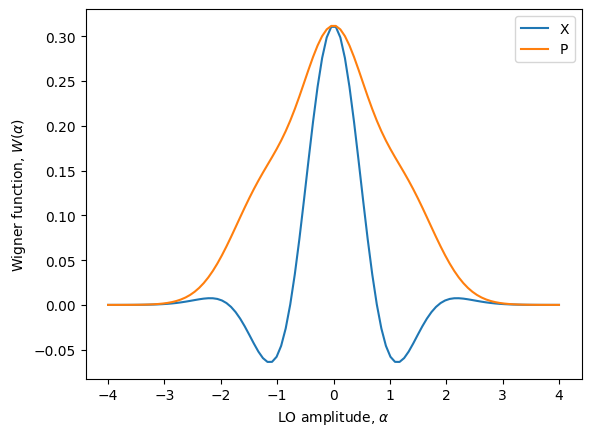

In [28]:
sequence = Pulse()
sequence.add(Pulse.dirac({'delay': 0}))
sequence.add(Pulse.dirac({'delay': np.log(2)}))

source = Source.two_level(pulse=sequence)
source.photon_statistics().display()

alphas = np.linspace(-4, 4, 100)
wignerX = source.wigner(alpha=alphas)
wignerP = source.wigner(alpha=[1.j * a for a in alphas])

plt.plot(wignerX.alphas, wignerX.points, label='X')
plt.plot(wignerX.alphas, wignerP.points, label='P')
plt.legend()
plt.xlabel('LO amplitude, $\\alpha$')
plt.ylabel('Wigner function, $W(\\alpha)$')
plt.show()

Let's compare that to the state $(|0\rangle + |2\rangle)/\sqrt{2}$ by manually setting the initial state of a fock(2) source.

Number  | Probability
0       | 0.50000
1       | 0.00000
2       | 0.50000
3       | 0.00000
4       | 0.00000



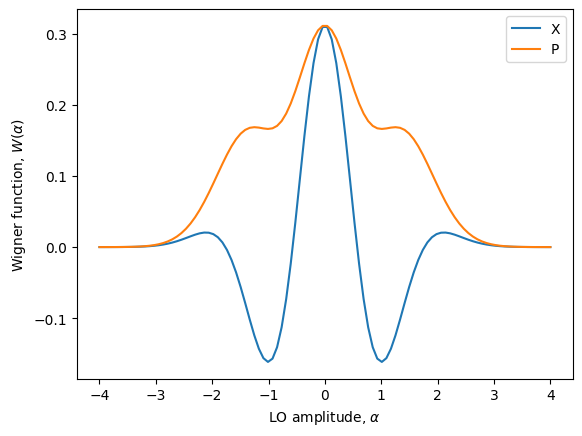

In [29]:
source = Source.fock(2)
source.initial_state = (source.states['|0>'] +  source.states['|2>'])/np.sqrt(2)
source.photon_statistics().display()

alphas = np.linspace(-4, 4, 100)
wignerX = source.wigner(alpha=alphas)
wignerP = source.wigner(alpha=[1.j * a for a in alphas])

plt.plot(wignerX.alphas, wignerX.points, label='X')
plt.plot(wignerX.alphas, wignerP.points, label='P')
plt.legend()
plt.xlabel('LO amplitude, $\\alpha$')
plt.ylabel('Wigner function, $W(\\alpha)$')
plt.show()

As we can see, the two cases both have $p_0=1/2$ and $p_2=1/2$ but their Wigner functions are not identical! This is because the correlations in the arrival time of the photons for the Bell state necessarily restricts a certain amount of coherence with the laser pulse.

## 3D plotting

Of course, we can also generate some 3D plots of the Wigner function in phase space if we are willing to wait some minutes. It's important to recognize that this is a fully general and direct numerical simulation of a time-integrated Wigner function produced by a pulsed quantum emitter. There are faster ways to simulate a Wigner function for continuous wave systems (those that are not pulsed) and also for states that can be easily written in terms of a single pulse mode, such as a perfect single photon. However, the ZPG method can broadly capture physical phenomena and imperfections that those more specialised approaches cannot.

In [30]:
sequence = Pulse()
sequence.add(Pulse.gaussian({'delay': 0, 'width': 0.03, 'area': np.pi}))  # let's see what happens if we apply pi
sequence.add(Pulse.gaussian({'delay': np.log(2), 'width': 0.04, 'area': np.pi/2}))  # then pi/2 with a slightly different width

source = Source.two_level(pulse=sequence, parameters={'dephasing': 0.1, 'detuning': 0.2}, efficiency=0.95)
mag = np.linspace(0.1, 4, 30)
phase = np.linspace(0, 2*np.pi, 30)
wigner = source.wigner(alpha=[m * np.exp(1.j * p) for m in mag for p in phase])
wigner = [[wigner.points[j + i * len(phase)] for i in range(0, len(mag))] for j in range(0, len(phase))]

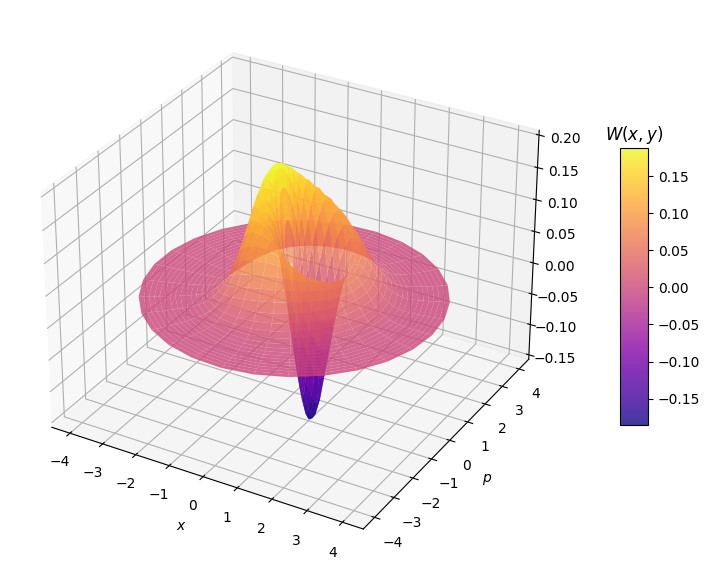

In [31]:
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(projection='3d')

R, P = np.meshgrid(mag, phase)
X, Y = R*np.cos(P), R*np.sin(P)
Z = np.array(wigner)
surf = ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8)

ax.set_zlim(-0.15, 0.2)
ax.set_xlabel('$x$')
ax.set_ylabel('$p$')
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_title('$W(x, y)$')
plt.show()

The result looks like a mixture between a single photon and a superposition between vacuum and a single photon. Although, we would find that it is not exactly this!